In [33]:
%matplotlib inline
import os

from cognite.client import CogniteClient
from cognite.model_hosting.data_spec import *
from cognite.model_hosting.data_fetcher import DataFetcher

API_KEY = os.getenv("COGNITE_API_KEY")
client = CogniteClient(api_key=API_KEY)
mlh = client.experimental.model_hosting

# Introduction

For this tutorial we will deploy a scheduled function which adds together two time series and multiplies them by pi.

The source package for this function is located in the "transform" directory.

First we will create a "model" container for deploying our model versions to.

In [34]:
model_id = mlh.models.create_model(
    name="my-simple-function",
    input_fields=[{"name": "x1", "type": "TIME_SERIES"}, {"name": "x2", "type": "TIME_SERIES"}],
    output_fields=[{"name": "y", "type": "TIME_SERIES"}],
).id

Then we upload our source package to the hosting environment

In [35]:
source_package_id = mlh.source_packages.build_and_upload_source_package(
    name="my-simple-function", 
    runtime_version="0.1", 
    package_directory="transform"
).id

Then we deploy our function as a model version

In [36]:
version_id = mlh.models.deploy_model_version(
    model_id=model_id,
    name="my-simple-function-v1",
    source_package_id=source_package_id,
).id

In [37]:
mlh.models.get_model_version(model_id, version_id).status

'READY'

Now we can create a schedule spec for defining which data we will pass to our function and how the input data will be traversed.

Here you can fill in your input and output time series.

In [38]:
INPUT_TS_1 = ...
INPUT_TS_2 = ...
OUTPUT_TS = ...

schedule_data_spec = ScheduleDataSpec(
    input=ScheduleInputSpec(
        time_series={
            "x1": ScheduleInputTimeSeriesSpec(id=INPUT_TS_1, aggregate="average", granularity="10s"),
            "x2": ScheduleInputTimeSeriesSpec(id=INPUT_TS_2, aggregate="average", granularity="10s")
        }
    ),
    output=ScheduleOutputSpec(
        time_series={
            "y": ScheduleOutputTimeSeriesSpec(id=OUTPUT_TS)
        }
    ),
    start="now",
    stride="1m",
    window_size="1m"
)



Then we can start the schedule

In [39]:
schedule_id = mlh.schedules.create_schedule(
    model_id=model_id,
    name="tutorial-schedule",
    schedule_data_spec=schedule_data_spec,
    description="Some description"
).id

Our output time series is now being updated every minute. Let's have a look!


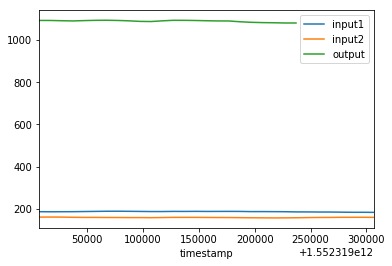

In [45]:
ds = DataSpec(time_series={
    "input1": TimeSeriesSpec(id=INPUT_TS_1, aggregate="average", granularity="10s", start="5m-ago", end="now"),
    "input2": TimeSeriesSpec(id=INPUT_TS_2, aggregate="average", granularity="10s", start="5m-ago", end="now"),
    "output": TimeSeriesSpec(id=OUTPUT_TS, aggregate="average", granularity="10s", start="5m-ago", end="now")
})

df = DataFetcher(ds).time_series.fetch_dataframe(["input1", "input2", "output"])
df.plot(x="timestamp")

Remember to clean up after yourself by deleting your model

In [46]:
mlh.models.delete_model(model_id)
mlh.source_packages.delete_source_package(source_package_id)